## Inference
Let's do the inference part to test the external data/images that I have downloaded from the google to see how our model performs with the external data. 

### Importing libraries
Let's import the libraries and enable GPU for dynamic memory allocation!

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf   

tf.get_logger().setLevel('ERROR')          # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
# Path to external images that I want to test the model on
IMAGE_PATHS = 'test_images/'

### Setting model path
Let's set up the paths!

In [3]:
CUSTOM_MODEL_NAME = 'birds_ssd_mobnet'

In [4]:
PATH_TO_MODEL_DIR = './Tensorflow/workspace/models/{}/saved_model/saved_model/'.format(CUSTOM_MODEL_NAME)

In [5]:
print(PATH_TO_MODEL_DIR)

./Tensorflow/workspace/models/birds_ssd_mobnet/saved_model/saved_model/


In [6]:
PATH_TO_LABELS = './Tensorflow/workspace/annotations/label_map.pbtxt'

## Object detection from TF2 saved model
The below code loads the saved model so that it can build the detection. The output shows the time that it took to load the model.

In [7]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 5.476233243942261 seconds


### Label map
The below code reads a label map and returns a category index. First argument is path to the labels whereas second argument is to choose whether to load 'display_name' field as category name or not.

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, 
                                                                    use_display_name=True)

### Loading an image with predictions
Puts image into numpy array to feed into tensorflow graph and finally seeing the prediction on the external images as the output.

Running inference for test_images/eretha2.jpg... Done
Running inference for test_images/picap2.jpg... Done
Running inference for test_images/picap1.jpg... Done
Running inference for test_images/periparus1.jpg... Done
Running inference for test_images/erethe1.jpg... Done
Running inference for test_images/peri2.jpg... Done


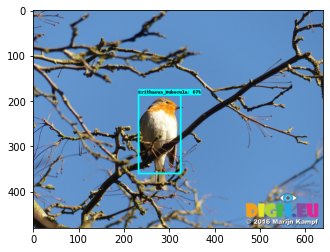

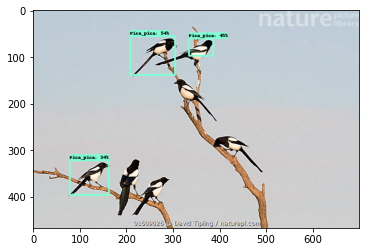

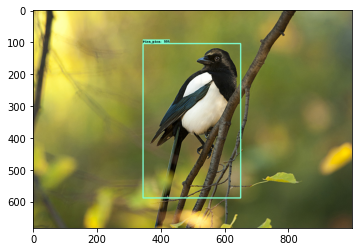

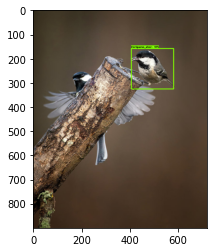

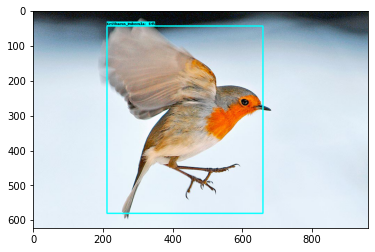

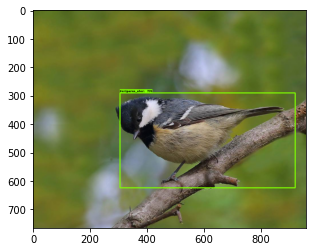

In [24]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore') # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

for image_path in os.listdir(IMAGE_PATHS):
    image_path = os.path.join(IMAGE_PATHS, image_path)
    
    print('Running inference for {}... '.format(image_path), end='')
    
    image_np = load_image_into_numpy_array(image_path)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# Conclusion

Finally, I'd like to highlight that the *Faster R-CNN* model outperformed the *SSD MobileNet* model in every parameter. Initially, I used the same config file parameter values for both models with 5000 training steps where *MobileNet* performed not good because it was having hard time recognised the birds. And even if it recongnises then either accuracy was low or wrongly classified the bird species in the images. This ensures that even with fewer steps, *Faster R-CNN* was able to function quite good.<br> 

After confirming this, I attempted to make both models as good as possible by modifying the config file values. You will receive modifications information for *Faster R-CNN* at the end of its *inference* jupyter file.<br> 

For *SSD MobileNet*:
- Initially, I attempted 5000 steps, gradually increasing 2000-3000 steps to 25000, but it was barely displaying any proper improvements after 20000 steps, so I chose to rerun the model again with 10000 steps as I was not able to remove trained steps after reaching to 25000 steps.
- Also, I experimented with several batch sizes, beginning with 64, 32, 16, and 10 to improve the performance of my model, but every time it got stuck at one point and ended the training process without even starting with a single step. 
- As it was already performing poorly as compared to Faster R-CNN so I choose to improve this model by increasing the batch_size to 4 and increasing the number the number of steps in training. 
- Finally, *min_score_thresh* value in above code was changed to 0.30 seems to be the optimal value after trying with different values because at 0.75 it was unable to find the binding boxes for the birds in the image meaning no detection was done. And below this value, for some of the image it was making too many bounding boxes even for a single bird with wrong predictions and less accuracy.